In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

data = pd.read_csv('cervical_cancer.csv')

data.replace('?', pd.NA, inplace=True)

data

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,<NA>,<NA>,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,<NA>,<NA>,0,0,0,0,0,0,0,0
2,34,1.0,<NA>,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,<NA>,<NA>,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,<NA>,<NA>,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,<NA>,<NA>,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,3.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,<NA>,<NA>,0,0,0,0,0,0,0,0
854,32,2.0,19.0,1.0,0.0,0.0,0.0,1.0,8.0,0.0,...,<NA>,<NA>,0,0,0,0,0,0,0,0
855,25,2.0,17.0,0.0,0.0,0.0,0.0,1.0,0.08,0.0,...,<NA>,<NA>,0,0,0,0,0,0,1,0
856,33,2.0,24.0,2.0,0.0,0.0,0.0,1.0,0.08,0.0,...,<NA>,<NA>,0,0,0,0,0,0,0,0


## Heatmap

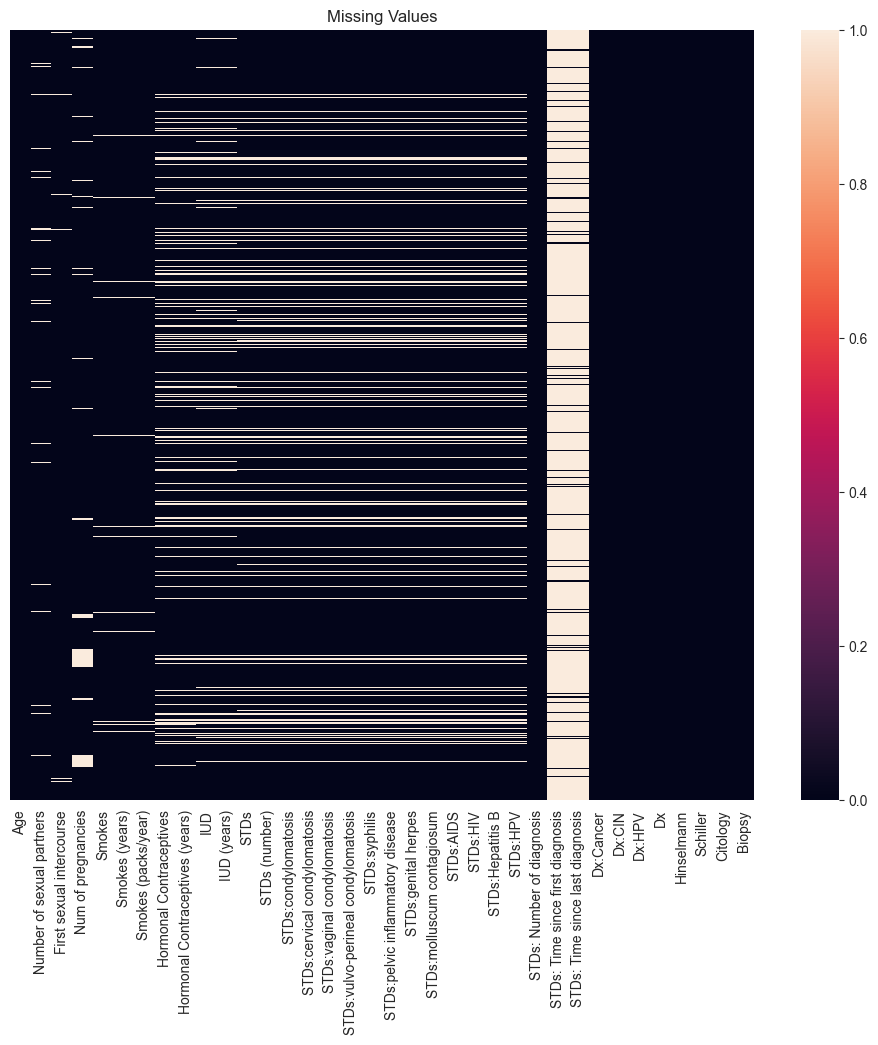

In [111]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.isnull(), yticklabels=False)
plt.title('Missing Values')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

<Axes: >

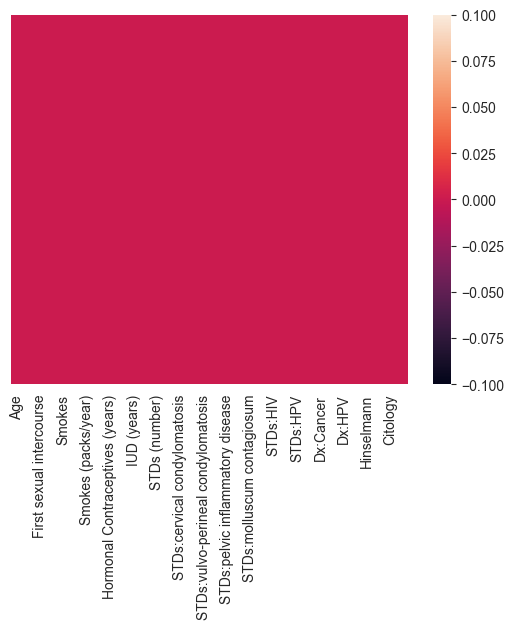

In [112]:
cancer_df = data.drop(columns = ['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'])
cancer_df = cancer_df.apply(pd.to_numeric, errors='coerce')
cancer_df.info()
cancer_df.fillna(cancer_df.mean(), inplace=True)
sns.heatmap(cancer_df.isnull(), yticklabels=False)

## Visualizing the Data

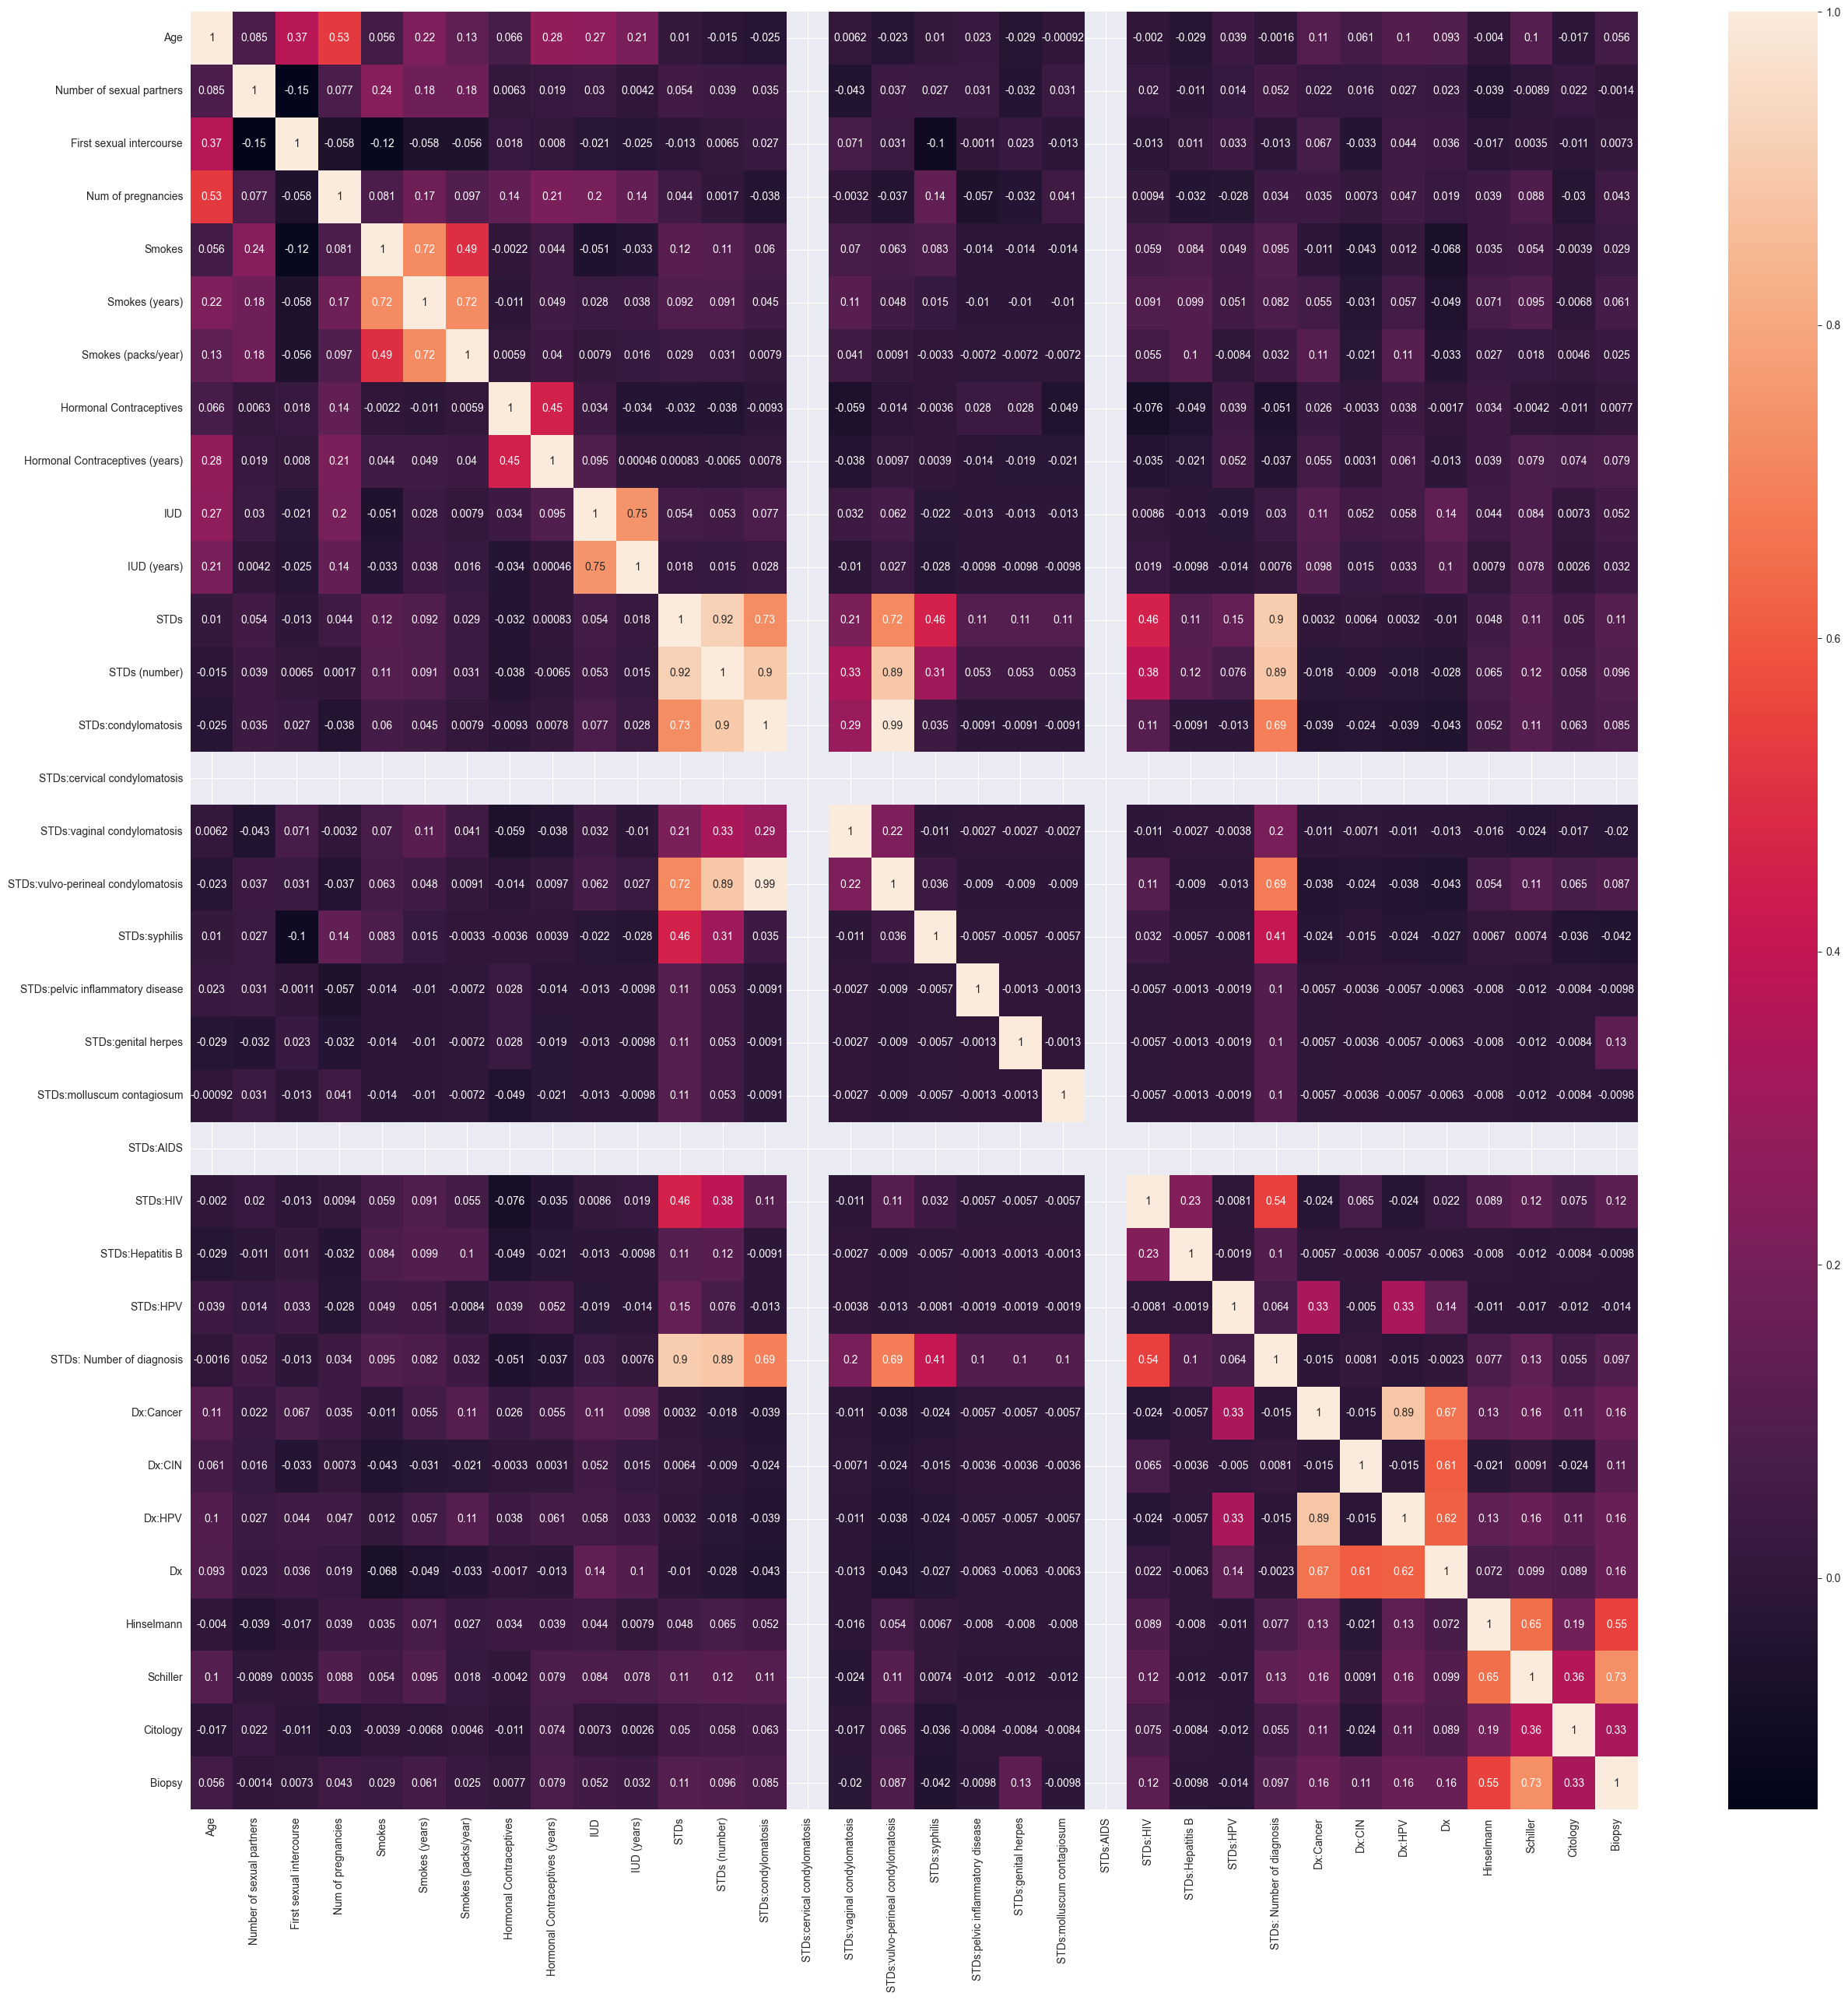

Biopsy                                1.000000
Schiller                              0.733204
Hinselmann                            0.547417
Citology                              0.327466
Dx:Cancer                             0.160905
Dx:HPV                                0.160905
Dx                                    0.157607
STDs:genital herpes                   0.129657
STDs:HIV                              0.124133
Dx:CIN                                0.113172
STDs                                  0.106737
STDs: Number of diagnosis             0.097449
STDs (number)                         0.096218
STDs:vulvo-perineal condylomatosis    0.086977
STDs:condylomatosis                   0.084520
Hormonal Contraceptives (years)       0.078995
Smokes (years)                        0.061484
Age                                   0.055956
IUD                                   0.051554
Num of pregnancies                    0.043460
IUD (years)                           0.032250
Smokes       

In [113]:
corr_matrix = cancer_df.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True)
plt.show()
print(corr_matrix['Biopsy'].sort_values(ascending=False))



In [114]:
feature_names = cancer_df.drop(columns=['Biopsy']).columns.tolist()
print(feature_names)

['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology']


## Prepare Data for Training

In [115]:
target = cancer_df['Biopsy']
input = cancer_df.drop(columns=['Biopsy'])
target.shape
input.shape
X = np.array(input).astype('float32')
y = np.array(target).astype('float32')
y.shape


(858,)

In [116]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-1.0385634e+00,  8.9706147e-01, -7.1509570e-01, ...,
        -2.0622157e-01, -3.0722591e-01, -2.3249528e-01],
       [-1.3917956e+00, -9.3074709e-01, -1.0734857e+00, ...,
        -2.0622157e-01, -3.0722591e-01, -2.3249528e-01],
       [ 8.4534228e-01, -9.3074709e-01,  2.2945171e-07, ...,
        -2.0622157e-01, -3.0722591e-01, -2.3249528e-01],
       ...,
       [-2.1435463e-01, -3.2147753e-01,  1.6845580e-03, ...,
        -2.0622157e-01, -3.0722591e-01,  4.3011627e+00],
       [ 7.2759819e-01, -3.2147753e-01,  2.5104153e+00, ...,
        -2.0622157e-01, -3.0722591e-01, -2.3249528e-01],
       [ 2.5662178e-01, -3.2147753e-01,  1.0768549e+00, ...,
        -2.0622157e-01, -3.0722591e-01, -2.3249528e-01]],
      shape=(858, 33), dtype=float32)

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Use XGBoost

In [118]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

model = xgb.XGBClassifier(learning_rate=.1, max_depth=5, n_estimators=10, scale_pos_weight=class_weights_dict[1])
model.fit(X_train, y_train)
results = model.score(X_train, y_train)
results

0.967930029154519

In [119]:
results = model.score(X_test, y_test)
results

0.9651162790697675

In [120]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        78
         1.0       0.73      1.00      0.84         8

    accuracy                           0.97        86
   macro avg       0.86      0.98      0.91        86
weighted avg       0.97      0.97      0.97        86



<Axes: >

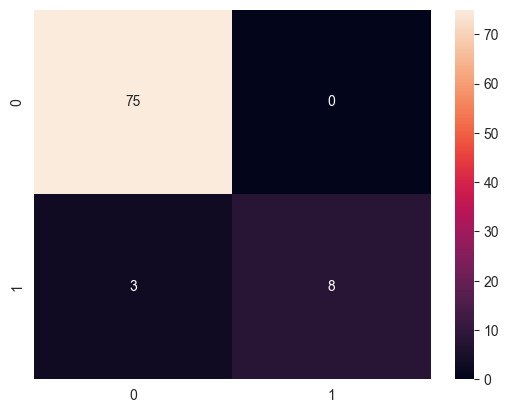

In [121]:
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True)

## Save Model and Scaler

In [122]:
import joblib

joblib.dump(model, 'cervical_cancer_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']